In [ ]:
#To install wandb package ,which is helpful in generating plots and report.
!pip install wandb

     |████████████████████████████████| 1.7 MB 12.5 MB/s 
     |████████████████████████████████| 181 kB 49.1 MB/s 
     |████████████████████████████████| 144 kB 47.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=dc26b75f3c493168555515047fc96ea08bbac5fd623514488738ea0a49e26912
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
# Essentials
import numpy as np
import tensorflow
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Activation
import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid

import random
import imageio
import os
import cv2
import glob
# random.seed(42)

### Download INaturalist Dataset from github repo

In [ ]:
# Load Dataset
!git clone https://github.com/ashwanth10/INaturalist_Dataset.git

Cloning into 'INaturalist_Dataset'...
remote: Enumerating objects: 12030, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 12030 (delta 0), reused 2 (delta 0), pack-reused 12026
Receiving objects: 100% (12030/12030), 3.55 GiB | 8.39 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (11999/11999), done.


## Preprocess Train & Test Data

In [ ]:
# Labels for INaturalist Dataset
class_labels = {
    0: 'Amphibia',
    1: 'Animalia',
    2: 'Arachnida',
    3: 'Aves',
    4: 'Fungi',
    5: 'Insecta', 
    6: 'Mammalia', 
    7: 'Mollusca', 
    8: 'Plantae',
    9: 'Reptilia'
}

num_classes = 10
img_size = 128
directory_train = 'INaturalist_Dataset/train'
directory_test  = 'INaturalist_Dataset/val'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        'INaturalist_Dataset/train',
        target_size=(128, 128),
        batch_size=9999,
        class_mode='categorical')

x_train,y_train = train_generator.next()

test_generator=ImageDataGenerator(rescale= 1./255).flow_from_directory(
        'INaturalist_Dataset/val',
        target_size=(128, 128),
        class_mode='categorical')

x_test,y_test = test_generator.next()

2fad1ed3a05629c089cd530f297e27e6.jpg
d192b73b0af85824c65e91f8795d8df7.jpg
aa66b3ba5ccffdb3c41c1d3acf7dd569.jpg


In [ ]:
# Set seed
np.random.seed(0)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.1, 
                                                  stratify=y_train,
                                                  random_state=42)

# Functions and some helper Functions

In [ ]:
def addActivation(model, activation_name):
    if activation_name == "relu":
        model.add(Activation('relu'))
    elif activation_name == "elu":
        model.add(Activation('elu'))
    elif activation_name == "selu":
        model.add(Activation('selu'))

In [ ]:
def configureBatchNormalization(model, do_batch_normalisation):
    if do_batch_normalisation:
        model.add(BatchNormalization())

In [ ]:
def calculateTestAccuracy(model,x_test,y_test):
  yhat=model.predict(x_test)
  yhat_max = np.argmax(yhat, axis=1)
  y_test_max = np.argmax(y_test, axis=1)
  y_test_max = y_test_max.reshape(-1)
  accuracy= (yhat_max == y_test_max).sum()/ y_test.shape[0]
  print('accuracy: ', accuracy)

In [ ]:
def train_with_params(x_train, y_train, x_val, y_val, x_test, y_test,
                      filter, kernel_size, input_shape, weight_decay, 
                      activation_name, do_batch_normalisation, neurons_in_dense,
                      dropout, num_classes, learning_rate, batch_size,
                      do_data_augmentation, manual_run=False):

    # clear session
    tensorflow.keras.backend.clear_session()

    # Set seed
    np.random.seed(0)
    
    # Define the model architecture
    model = Sequential()

    # no. of convolution layers
    NUM_OF_CONV_LAYERS = 5

    for i in range(NUM_OF_CONV_LAYERS):
        model.add(Conv2D(filters = filter[i], kernel_size = kernel_size[i],
                          padding = 'same', input_shape = input_shape, 
                          kernel_regularizer=regularizers.l2(weight_decay)))
        
        addActivation(model, activation_name)
        configureBatchNormalization(model, do_batch_normalisation)
        model.add(MaxPooling2D(pool_size=(2, 2))) 
    
    # Fully connected  layer
    model.add(Flatten())
    model.add(Dense(neurons_in_dense, activation=activation_name, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation = "softmax"))

    # Define the optimizer
    optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    # Data augmentation
    if do_data_augmentation:
        datagen = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.1, horizontal_flip=True, vertical_flip=False)
    else:
        datagen = ImageDataGenerator(rescale = 1.0)

    datagen.fit(x_train)
    
    # Call Wandb Only when initiated from Wandb.
    if manual_run:
        model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs = 20,
        verbose = 1,
        validation_data= (x_val, y_val))
    else: 
        model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs = 20,
        verbose = 1,
        validation_data= (x_val, y_val),
        batch_size=batch_size,
        callbacks = [WandbCallback()])

    # Calculate accuracy of the model
    calculateTestAccuracy(model, x_test, y_test)
    model.save('/content/drive/MyDrive/Models/model.keras')
    
    return model

In [ ]:
# Given an image path, return the loaded_image and the image_tensor
def get_image_tensor(image_path):
  loaded_image = image.load_img(image_path, target_size=(128, 128))
  image_tensor = image.img_to_array(loaded_image)
  image_tensor = np.expand_dims(image_tensor, axis=0)
  return loaded_image,image_tensor

In [ ]:
# Given the no. of rows, cols and images, plots the images.
def plot_the_figure(rows,cols,images):
  figure = plt.figure(figsize=(18, 18.))
  grid = ImageGrid(figure, 111,nrows_ncols=(rows, cols),axes_pad=0.3)
  for axes, img in zip(grid, images):
      axes.imshow(img)
      axes.axis('off')
  plt.show()

## WandB Config Params for the Sweeps

In [ ]:
sweep_config = {
    'method': 'random', 
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'weight_decay': {
            'values': [0, 0.0005, 0.005]
        },
        'dropout': {
            'values': [0, 0.2, 0.4]
        },
        'activation': {
            'values': ['relu', 'elu', 'selu']
        },
        'data_augment': {
            'values': [True, False]
        },
        'batch_norm':{
            'values': [True, False]
        },
        'batch_size': {
            'values': [32, 64]
        },
        'kernel_size':{
            'values': [[(3,3),(3,3),(3,3),(3,3),(3,3)], [(5,5), (5,5), (5,5), (5,5), (5,5)], [(7,7),(7,7),(5,5),(5,5),(3,3)], [(3,3),(5,5),(7,7),(9,9),(11,11)] ]
        },
        'filt_org':{
            'values': [[32,32,32,32,32],[32,64,64,128,128],[128,128,64,64,32],[32,64,128,256,512]]
        },
        'num_dense':{
            'values': [64, 128, 256, 512]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="cs21m010-cs21m041", project="DL_Assignment_2")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 65586bci
Sweep URL: https://wandb.ai/cs21m010-cs21m041/DL_Assignment_2/sweeps/65586bci


# Run WandB Sweeps

In [ ]:
def train():

    # Create a new WandB run
    wandb.init(config=sweep_config)
    
    # Construct the run name
    config = wandb.config
    wandb.run.name = 'num_dense_'+ str(config.num_dense)+'_bs_'+str(config.batch_size)+'_ac_'+ config.activation
    
    # Create a tuple of input shape
    input_shape = (img_size, img_size , 3)

    # Train with the params decided by the wandb config
    train_with_params(x_train, y_train, x_val, y_val, x_test, y_test,
                      config.filt_org, config.kernel_size, input_shape, 
                      config.weight_decay, config.activation, config.batch_norm, 
                      config.num_dense, config.dropout, num_classes, 
                      config.learning_rate, config.batch_size, config.data_augment)
    

In [ ]:
wandb.agent(sweep_id, train, count = 15)

wandb: Agent Starting Run: ujdrle2q with config:
wandb: 	activation: elu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augment: True
wandb: 	dropout: 0.4
wandb: 	filt_org: [128, 128, 64, 64, 32]
wandb: 	kernel_size: [[3, 3], [5, 5], [7, 7], [9, 9], [11, 11]]
wandb: 	learning_rate: 0.001
wandb: 	num_dense: 64
wandb: 	weight_decay: 0.0005
wandb: Currently logged in as: harishpilla (use `wandb login --relogin` to force relogin)


# Get the Best Model

In [ ]:
# Best Config of Hyperparameters

learning_rate = 0.0001
activation = 'relu'
weight_decay = 0.0005
data_augmentation = True
num_of_neurons_in_dense = 512
dropout = 0.2
batch_size = 64
batch_norm = False
filt_org = [32,64,128,256,512]
kernel_size = [(5,5),(5,5),(5,5),(5,5),(5,5)]
input_shape = (img_size, img_size , 3)

model = train_with_params(x_train, y_train, x_val, y_val, x_test, y_test,
                      filt_org, kernel_size, input_shape, 
                      weight_decay, activation, batch_norm, 
                      num_of_neurons_in_dense, dropout, num_classes, 
                      learning_rate, batch_size, data_augmentation, manual_run=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
141/141 [==============================] - 54s 301ms/step - loss: 5.8088 - accuracy: 0.1669 - val_loss: 5.0959 - val_accuracy: 0.2170
Epoch 2/5
141/141 [==============================] - 41s 290ms/step - loss: 4.5360 - accuracy: 0.2118 - val_loss: 4.2459 - val_accuracy: 0.2860
Epoch 3/5
141/141 [==============================] - 41s 288ms/step - loss: 3.8801 - accuracy: 0.2389 - val_loss: 3.7042 - val_accuracy: 0.2390
Epoch 4/5
141/141 [==============================] - 41s 288ms/step - loss: 3.4730 - accuracy: 0.2552 - val_loss: 3.3123 - val_accuracy: 0.2990
Epoch 5/5
141/141 [==============================] - 40s 285ms/step - loss: 3.1983 - accuracy: 0.2702 - val_loss: 3.0445 - val_accuracy: 0.2970
accuracy:  0.293


# Visualize few sample images and plot filters

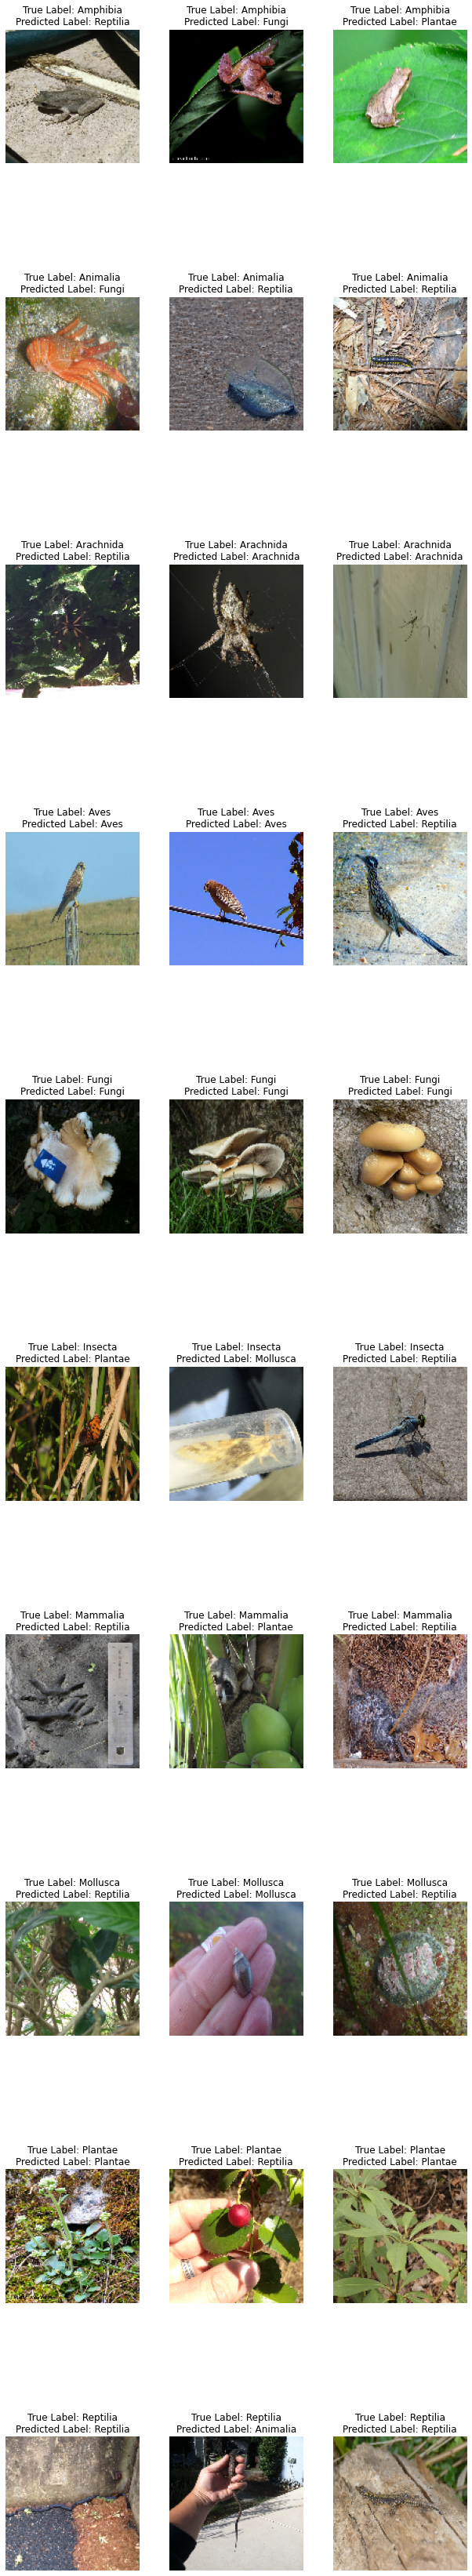

In [ ]:
test_data_images = []
test_data_labels = []

# Iterate over each class_label and capture 3 images of each class
for label, name in class_labels.items():
    images_of_a_class = os.listdir(directory_test + '/' + name)

    # Capture 3 random images
    for index in range(3):
        randomIndex = random.randint(0, 199)

        # Read the image
        selected_image = imageio.imread(directory_test + '/' + name + '/' + images_of_a_class[randomIndex])

        # Consider images only if are RGB colors
        if np.ndim(selected_image) == 3:
            test_data_images.append(cv2.resize(selected_image, (img_size,img_size)))
            test_data_labels.append(class_labels[label])

# Convert the images to numpy arrays and normalize
test_data_images = np.array(test_data_images)
test_data_images = test_data_images / 255

# Plotting a small subset of classes and labels
fig = plt.figure(figsize=(60,50))

gridspec_obj = gridspec.GridSpec(10, 3, width_ratios=[1, 1, 1], wspace=0.0, hspace=1.0, top=0.95, bottom=0.05, left=0.7, right=0.845) 
k = 0
for i in range(10):
    for index in range(3):
      img_subplot = plt.subplot(gridspec_obj[i, index])
      visualized_image = test_data_images[k]
      img_subplot.imshow(visualized_image)
      true_label = test_data_labels[k]
      k += 1

      # Predict the label and show titles of both true/predicted labels
      predicted_label = model.predict(visualized_image.reshape(1,128, 128, 3))[0]
      img_subplot.set_title("True Label: {}\nPredicted Label: {}".format(true_label, class_labels[np.argmax(predicted_label)]))
      img_subplot.axis('off')

plt.show()


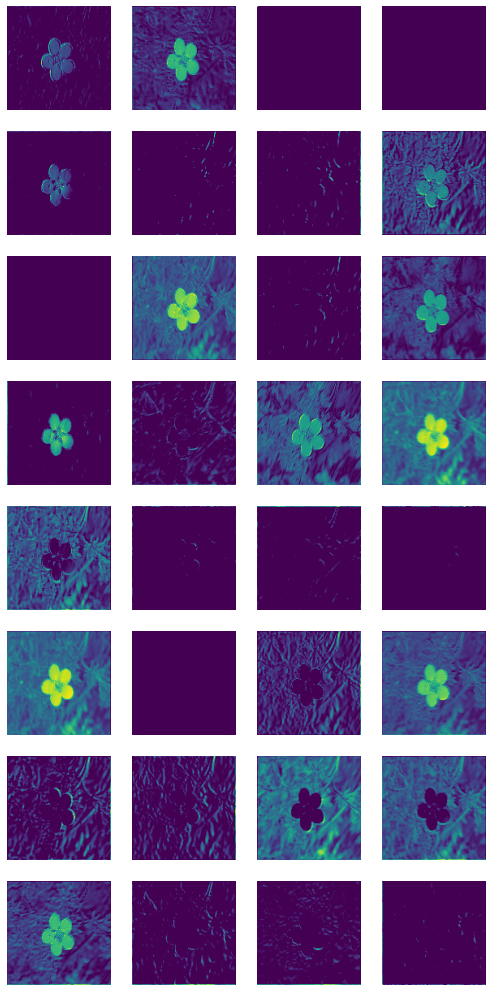

In [ ]:
# Visualsing the filters for the first layer

# Getting the image path
image_path = 'INaturalist_Dataset/val/Plantae/81c7385963754450403e579ff492a90e.jpg'
image_tensor = get_image_tensor(image_path)

# Loading the model and getting the first layer
model = tf.keras.models.load_model('/content/drive/MyDrive/Models/model.keras')
first_layer_model = tf.keras.models.Model(inputs=model.input,outputs=model.layers[1].output)
first_layer_output = first_layer_model.predict(image_tensor[1])

images=[]
for i in range(32) :
    images.append(first_layer_output[0][:,:,i])

# plotting the figure
plot_the_figure(8,4,images)

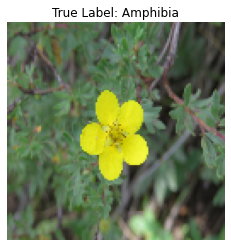

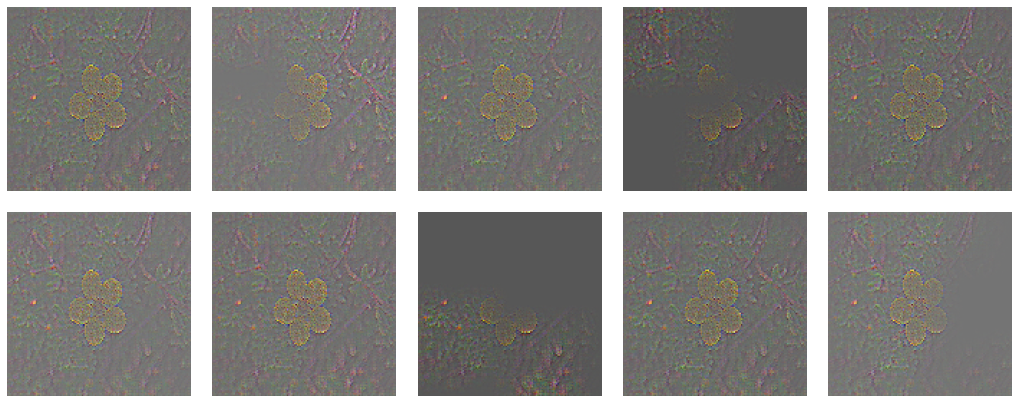

In [ ]:
# Guided Back Propagation

image_path = 'INaturalist_Dataset/val/Plantae/81c7385963754450403e579ff492a90e.jpg'
loaded_image,image_tensor = get_image_tensor(image_path)

# Display the image tensor
plt.imshow(loaded_image)
plt.title("True Label: " + test_data_labels[index])
plt.axis("off")
plt.show()

# Creating custom gradients
@tf.custom_gradient
def guidedRelU(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

# Apply guided ReLu on activation layers 
for layer in model.layers[1:]:
    if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelU

gradients=[]
for i in [2,5, 13,18, 19, 20, 23, 25, 30, 31]:
  neuron_output = tf.keras.activations.relu(model.get_layer("conv2d_4").output[:,:,:,i])
  neuron = tf.keras.models.Model(inputs = [model.inputs],outputs = [neuron_output])

  # Compute gradients
  with tf.GradientTape() as g:
    inputs = tf.cast(image_tensor, tf.float32)
    g.watch(inputs)
    outputs = neuron(inputs)

  gradients.append(g.gradient(outputs,inputs).numpy()[0])

# Create images using the calculated gradients
images=[]
for gradient in gradients:
  grad_image = np.dstack((
              gradient[:, :, 0],
              gradient[:, :, 1],
              gradient[:, :, 2],
          ))       
  grad_image = grad_image - np.min(grad_image)
  grad_image = grad_image/grad_image.max()
  images.append(grad_image)

plot_the_figure(2,5,images)